In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# Determine the optimal number of clusters in the data using gap statistics

## Imports

In [2]:
from tqdm import tqdm
import numpy as np

from sklearn.cluster import KMeans
from gap_statistic import OptimalK
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import matplotlib.pyplot as plt

import torch

from src.metrics.distribution_measures import Encoder
from src.data.dataset_updated import MakeDataLoader
from src.utils import get_device

## Configs

In [3]:
path_encoder = '../models/cVAE/parameter_state_dict_Encoder.pth'
# dataset parameters
folder_images = '/home/kinakh/Datasets/galaxy-zoo/images_training_rev1/'
file_labels = '/home/kinakh/Datasets/galaxy-zoo/training_solutions_rev1.csv'
size = 64
augmented = False
batch_size = 64

# cluster parameters
min_cluster = 2
max_cluster = 100

device = get_device()

## Load encoder

In [4]:
encoder = Encoder()
ckpt = torch.load(path_encoder)
res = encoder.load_state_dict(ckpt)
print(f'Loading: {res}')

encoder.to(device)
encoder.eval();

Loading: <All keys matched successfully>


## Load data

In [5]:
make_dl = MakeDataLoader(folder_images, file_labels, size, augmented=augmented)
dl = make_dl.get_data_loader_valid(batch_size=batch_size)

## Compute latents

In [6]:
latents = []


for images, _ in tqdm(dl):
    images = images.to(device)
    
    with torch.no_grad():
        mu, _ = encoder(images)
    latents.extend(mu.detach().cpu().numpy())
print(f'Number of latents: {len(latents)}')
latents = np.array(latents)

100%|██████████| 48/48 [00:06<00:00,  7.96it/s]

Number of latents: 3072


## Run gap statistics

In [7]:
def KMeans_clustering_func(X, k):
    """ 
    K Means Clustering function, which uses the K Means model from sklearn.
    
    These user-defined functions *must* take the X (input features) and a k 
    when initializing OptimalK
    """
    
    # Include any clustering Algorithm that can return cluster centers
    
    m = KMeans(random_state=11, n_clusters=k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

In [8]:
optimalK = OptimalK(clusterer=KMeans_clustering_func)

In [9]:
#--------------------Run optimal K on the input data (subset_scaled_interim) and number of clusters
n_clusters = optimalK(latents, cluster_array=np.arange(min_cluster, max_cluster))
print('Optimal clusters: ', n_clusters)

Optimal clusters:  98


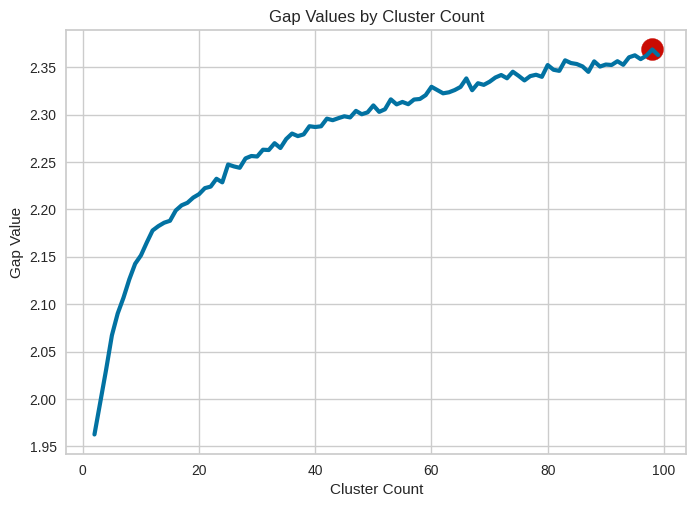

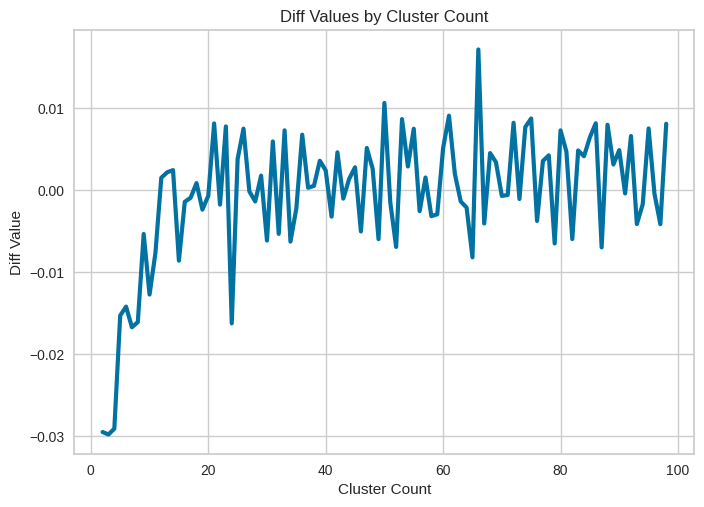

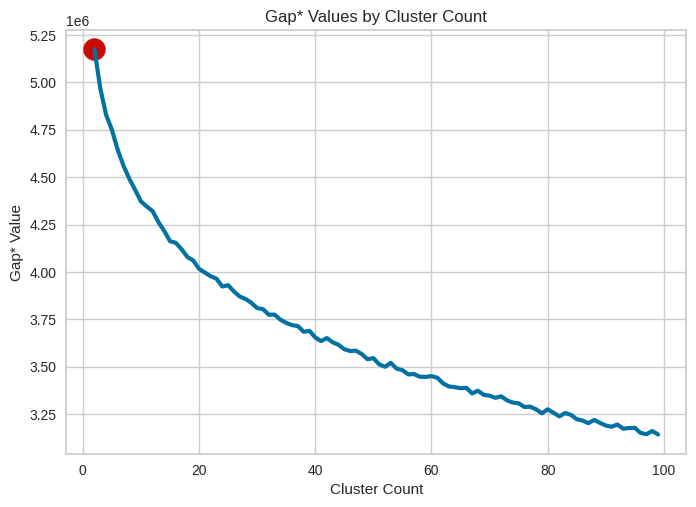

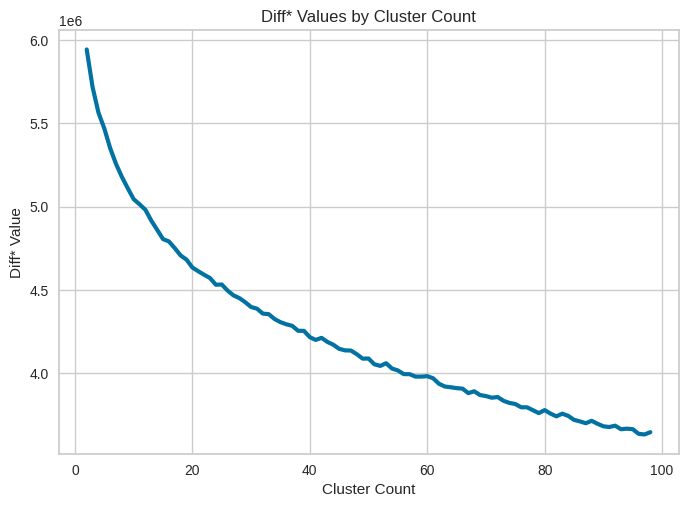

In [10]:
optimalK.plot_results()

In [11]:
optimalK.gap_df[['n_clusters', 'gap_value']]

,n_clusters,gap_value
0,2.0,1.962565
1,3.0,1.996600
2,4.0,2.030742
3,5.0,2.067121
4,6.0,2.090256
...,...,...
93,95.0,2.362629
94,96.0,2.358612
95,97.0,2.362375
96,98.0,2.368793


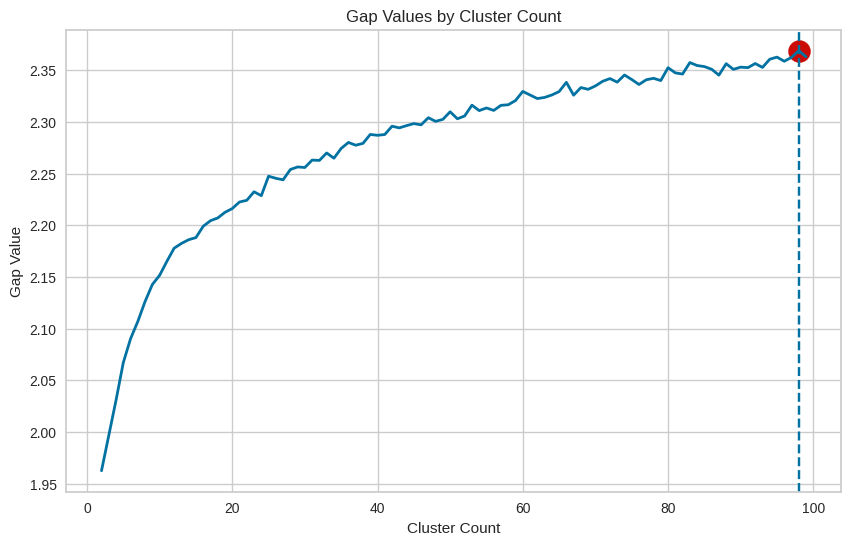

In [12]:
plt.figure(figsize=(10,6))
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=2)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.axvline(n_clusters, linestyle="--")
plt.show()

In [13]:
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
dst = scipy.spatial.distance.euclidean

def gap(data, refs=None, nrefs=20, ks=range(1,11)):
    """
    Compute the Gap statistic for an nxm dataset in data.

    Either give a precomputed set of reference distributions in refs as an (n,m,k) scipy array,
    or state the number k of reference distributions in nrefs for automatic generation with a
    uniformed distribution within the bounding box of data.

    Give the list of k-values for which you want to compute the statistic in ks.
    """
    shape = data.shape
    if refs==None:
        tops = data.max(axis=0)
        bots = data.min(axis=0)
        dists = scipy.matrix(scipy.diag(tops-bots))
        
        rands = scipy.random.random_sample(size=(shape[0],shape[1],nrefs))
        for i in range(nrefs):
            rands[:,:,i] = rands[:,:,i]*dists+bots
    else:
        rands = refs
    gaps = scipy.zeros((len(ks),))
    for (i,k) in enumerate(ks):
        (kmc,kml) = scipy.cluster.vq.kmeans2(data, k)
        disp = sum([dst(data[m,:],kmc[kml[m],:]) for m in range(shape[0])])
        refdisps = scipy.zeros((rands.shape[2],))
        for j in range(rands.shape[2]):
            (kmc,kml) = scipy.cluster.vq.kmeans2(rands[:,:,j], k)
            refdisps[j] = sum([dst(rands[m,:,j],kmc[kml[m],:]) for m in range(shape[0])])
        gaps[i] = scipy.log(scipy.mean(refdisps))-scipy.log(disp)
    return gaps

In [14]:
gaps = gap(latents, ks=range(min_cluster, max_cluster))

In [15]:
ks = list(range(min_cluster, max_cluster))

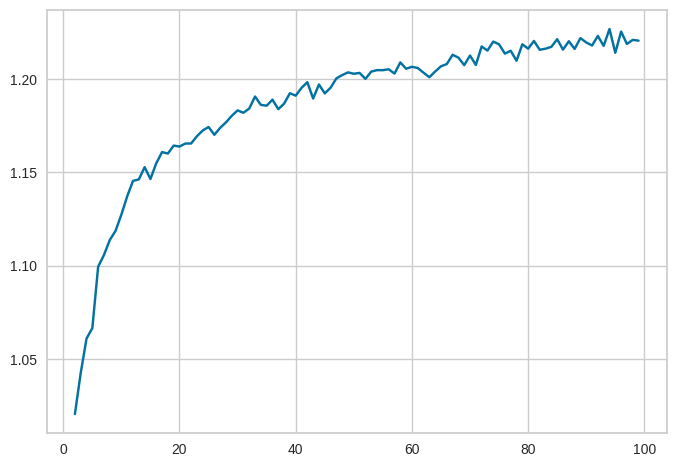

In [16]:
plt.figure()
plt.plot(ks, gaps)

In [17]:
n_clusters = ks[np.argmax(gaps)]
print(f'Optimal number of clusters: {n_clusters}')

Optimal number of clusters: 94


## Calinski-Harabasz Index

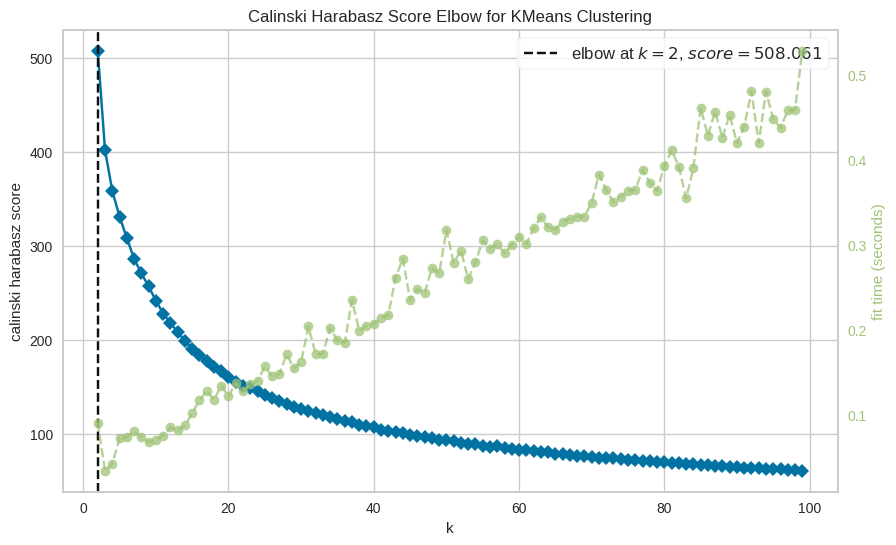

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [18]:
plt.figure(figsize=(10,6))
model = KMeans(random_state=1)
# k is a range of the number of clusters.
visualizer = KElbowVisualizer(
    model, k=(min_cluster, max_cluster), metric="calinski_harabasz", timings=True
)
visualizer.fit(latents)  # Fit the data to the visualizer
visualizer.show()  # Finalize and generate the plot

## Davies Bouldin Index


In [19]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering


def get_Hmeans_score(
    data, distance, link, center
):  #--------------------- We can specify linkage and distance
    """
    returns the  score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit Agglomerative to
        distance - the distance for AgglomerativeClustering
        link - the linkage method for AgglomerativeClustering
        center - the number of clusters you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the Hierarchical model fit to the data
    """
    #---------------instantiate Hierarchical Clustering
    
    hmeans = AgglomerativeClustering(n_clusters=center, affinity=distance, linkage=link)
    
    #---------------Then fit the model to the data using the fit method
    model = hmeans.fit_predict(data)
#---------------Calculate Davies Bouldin score
    score = davies_bouldin_score(data, model)
    return score

In [20]:
centers = list(range(min_cluster, max_cluster)) #------Number of Clusters in the data
avg_scores = []
for center in centers:
    avg_scores.append(get_Hmeans_score(latents, 'euclidean', 'average', center))

Text(0.5, 1.0, 'Davies Bouldin score vs. K')

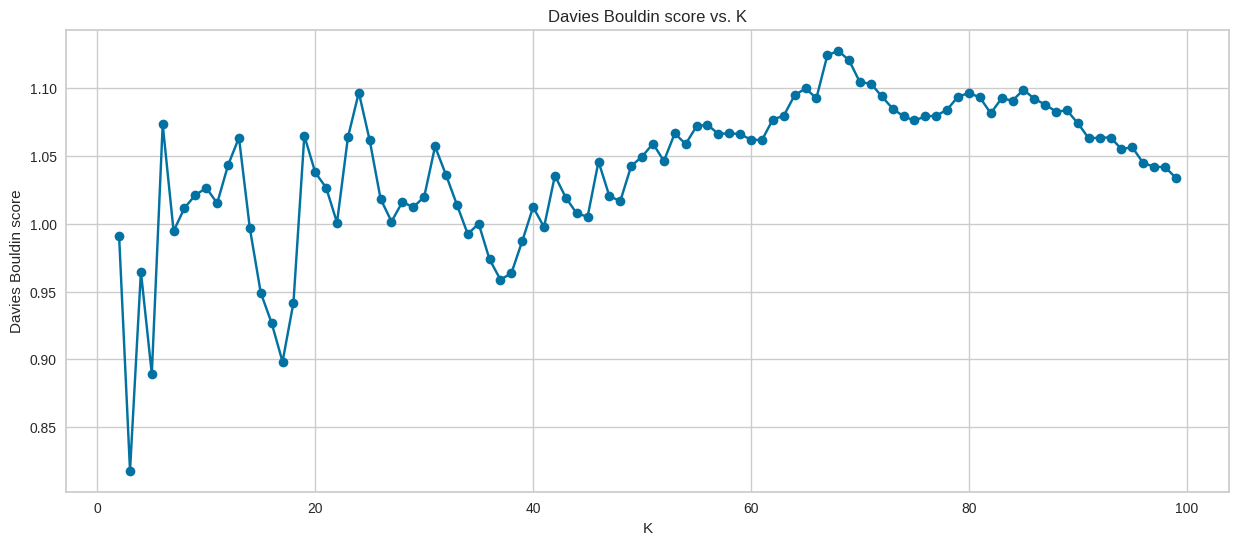

In [21]:
plt.figure(figsize=(15,6));
 
plt.plot(centers, avg_scores, linestyle='-', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Davies Bouldin score')
plt.title('Davies Bouldin score vs. K')

In [22]:
print(f'optimal number of clusters: {centers[np.argmin(avg_scores)]}')

optimal number of clusters: 3


In [23]:
## Gap statistics

In [24]:
import pandas as pd

In [25]:
# Gap Statistic for K means
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})

    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

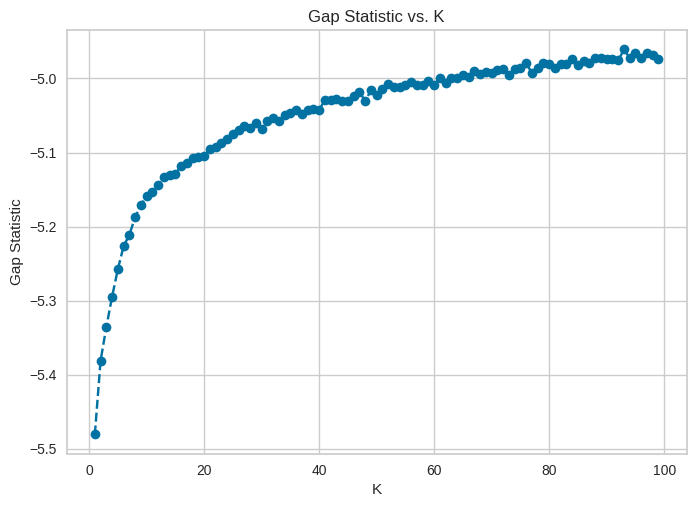

In [26]:
score_g, df = optimalK(latents, nrefs=5, maxClusters=100)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');

In [27]:
cluster_count = df['clusterCount']
gap = df['gap']

In [28]:
print(f'Best number of clusters: {cluster_count[np.argmax(gap)]}')

Best number of clusters: 93.0


## Silhouette Coefficient

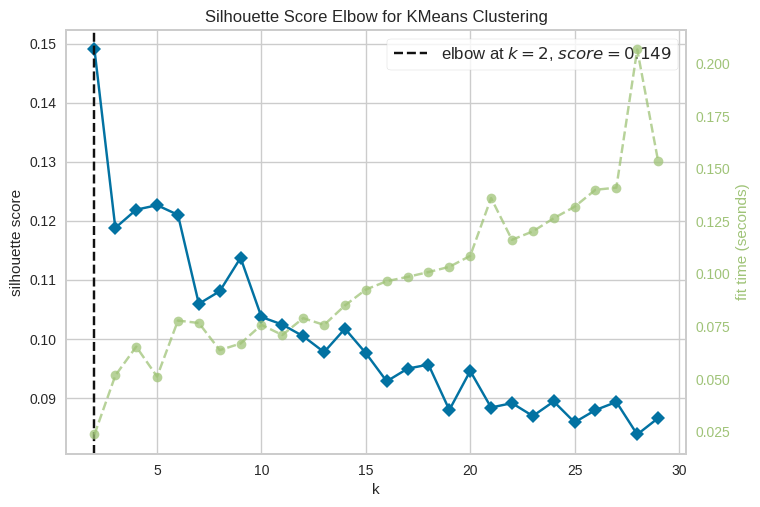

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [29]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='silhouette', timings= True)
visualizer.fit(latents)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Dendrogram

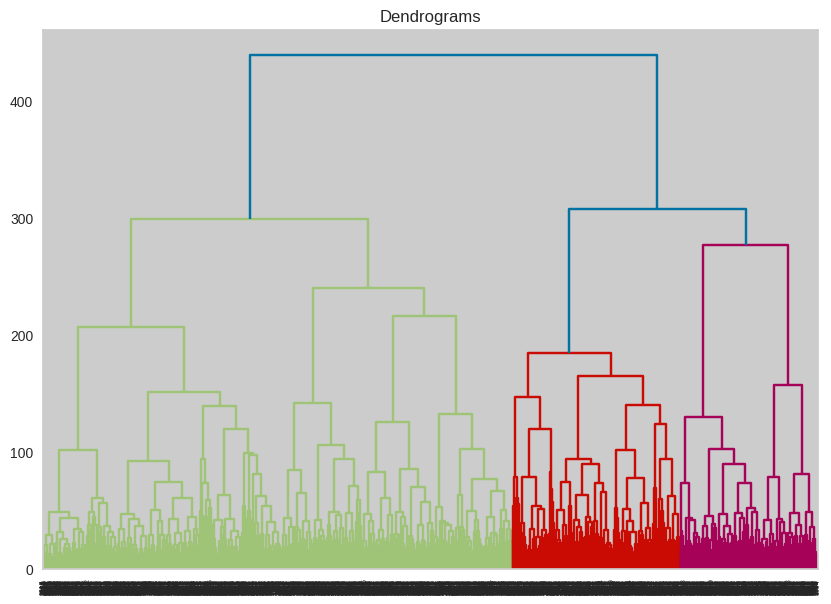

In [30]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(latents, method='ward'))

## Bayesian information criterion


In [31]:
from sklearn.mixture import GaussianMixture
n_components = range(1, 50)
covariance_type = ['spherical', 'tied', 'diag', 'full']
score=[]
for cov in covariance_type:
    for n_comp in n_components:
        gmm=GaussianMixture(n_components=n_comp,covariance_type=cov)
        gmm.fit(latents)
        score.append((cov,n_comp,gmm.bic(latents)))

In [32]:
min_score = 1e10
min_pos = -1

for i in range(len(score)):
    t, n_cluster, curr_score = score[i]
    
    if min_score > curr_score:
        min_score = curr_score
        min_pos = i

In [33]:
min_score, score[min_pos]

(256512.0455033777, ('full', 5, 256512.0455033777))